In [44]:
# Import required modules
import pandas as pd
import re
import numpy as np
import nltk
from matplotlib import pyplot as plt

%matplotlib inline
# Read the data from file into the variables
train_df = pd.read_csv('Data\Twitter_Train.csv') 
test_df = pd.read_csv('Data\Twitter_Test.csv')
# Combine the train and test data for the ease in preprocessing.
combi = train_df.append(test_df,ignore_index=True, sort=False)

In [45]:
#Define function to remove any predefined pattern 
def remove_pattern(text,pattern):
    all_patterns = re.findall(pattern,text)
    for i in all_patterns:
        text = re.sub(i,'',text)
    return text      


In [46]:
# Remove twitter handllers @user
v_remove_pattern = np.vectorize(remove_pattern)
combi['tidy_tweet'] = v_remove_pattern(combi['tweet'],'@[\w]*') 
# Remove any word of length less than 4
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x :  ' '.join([w for w in x.split() if len(w) > 3]))

In [47]:
# Lemmatize the words in tweets
tokenized_tweets  = combi['tidy_tweet'].apply(lambda x : nltk.word_tokenize(x))

In [48]:
# Perform Lemmetizetion on the data
lemmer = nltk.stem.WordNetLemmatizer()
#WordNet is a semantically-oriented dictionary of English included in NLTK.
#Lemmetize the tokens
def Lemmatizer(list_of_tokens):
    return [lemmer.lemmatize(token) for token in list_of_tokens]
tokenized_tweets = tokenized_tweets.apply(lambda x : Lemmatizer(x))

In [49]:
# convert the tokens back into texts and put it back in combi tweets
tokenized_tweets = tokenized_tweets.apply(lambda x : ' '.join([w for w in x]))
combi['tidy_tweet']  = tokenized_tweets

In [50]:
# Understanding common words used in the tweets
# A wordcloud is a visualization wherein the most
# frequent words appear in large size and the less frequent words appear in smaller sizes.
all_words = ' ' .join (text for text in combi['tidy_tweet'])
# all_words

from wordcloud import WordCloud
wordcloud = WordCloud(width=800,height=500,random_state = 0,max_font_size=80).generate(all_words)



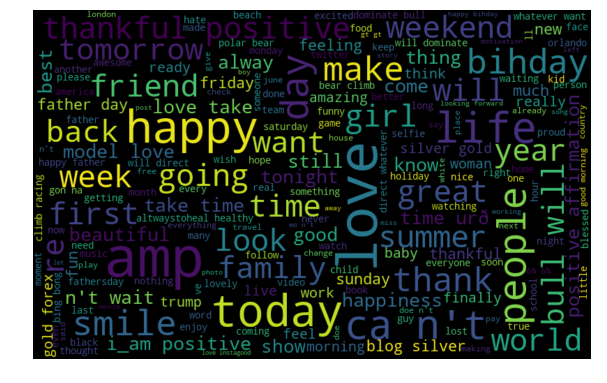

In [56]:
fig = plt.figure(figsize=(10,15))
plt.imshow(wordcloud,interpolation="bilinear");
plt.axis('off')
plt.show()

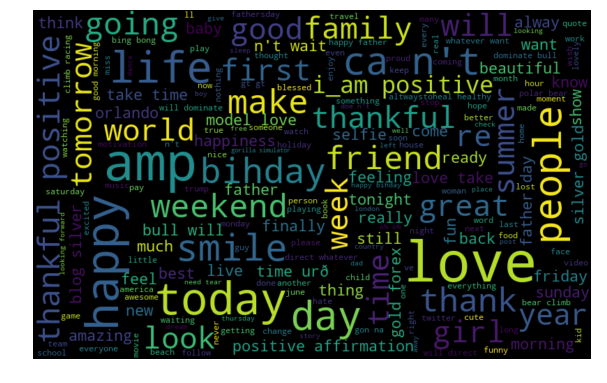

In [67]:
# # Finding normal words
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])
normal_wordcloud = WordCloud(width=800,height=500,random_state = 0,max_font_size=80).generate(normal_words)
fig = plt.figure(figsize=(10,15))
plt.imshow(normal_wordcloud,interpolation="bilinear");
plt.axis('off')
plt.show()

# normal_wordcloud

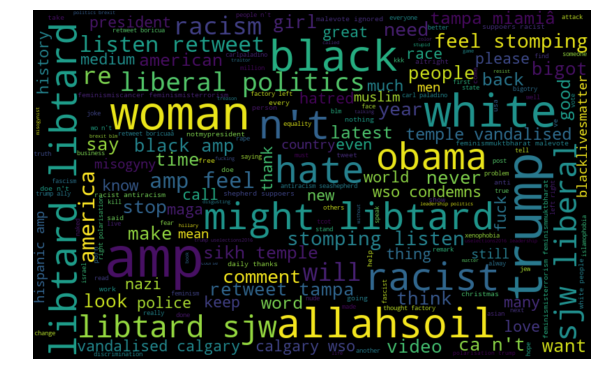

In [72]:
# Finding normal words
abnormal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
abnormal_wordcloud = WordCloud(width=800,height=500,random_state = 0,max_font_size=80).generate(abnormal_words)
fig = plt.figure(figsize=(10,15))
plt.imshow(abnormal_wordcloud,interpolation="bilinear");
plt.axis('off')
plt.show()


In [85]:
# Idetify the impact of hash_tags on the tweets sentiment

def extract_hashtags(text):
    hashtags = []
#     loop over the words in tweets
    for i in text:
        ht = re.findall(r'#\s[\w]+',i)
        hashtags.append(ht)
    return hashtags    

In [87]:
# Extract hashtags from the normal and abmnormal tweets
normal_ht = extract_hashtags(combi['tidy_tweet'][combi['label']==0])
abnormal_ht = extract_hashtags(combi['tidy_tweet'][combi['label']==1])
normal_ht = sum(normal_ht,[])
abnormal_ht = sum(abnormal_ht,[])


In [125]:
# normal Tweets
freq_dist_normal = nltk.FreqDist(normal_ht)
freq_dist_top_10_normal = freq_dist_normal.most_common(10)
freq_dist_df_normal = pd.DataFrame({'HashTags' : list(freq_dist_normal.keys()), 'Count' : list(freq_dist_normal.values())})
freq_dist_df_normal = freq_dist_df_normal.nlargest(columns='Count',n=10)

# Abnormal Tweets
freq_dist_abnormal = nltk.FreqDist(abnormal_ht)
freq_dist_top_10_abnormal = freq_dist_abnormal.most_common(10)
freq_dist_df_abnormal = pd.DataFrame({'HashTags' : list(freq_dist_abnormal.keys()), 'Count' : list(freq_dist_abnormal.values())})
freq_dist_df_abnormal = freq_dist_df_abnormal.nlargest(columns='Count',n=10)


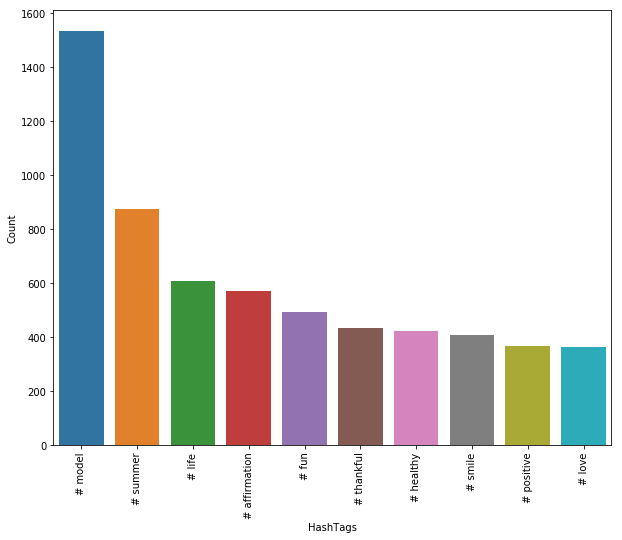

In [126]:
# Plot normal tweets
import seaborn as sns
fig = plt.figure(figsize=(10,8))
ax = sns.barplot(data = freq_dist_df_normal , x = 'HashTags', y = 'Count')
loc, labels = plt.xticks()
ax.set(ylabel='Count');
ax.set_xticklabels(labels[::-1],rotation=90);

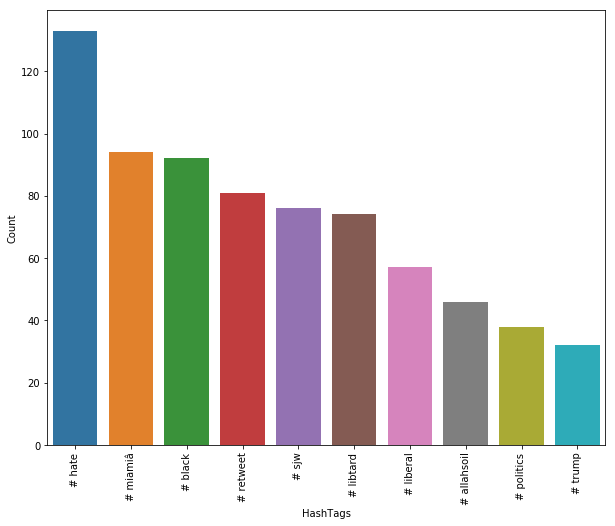

In [127]:
# Plot normal tweets
import seaborn as sns
fig = plt.figure(figsize=(10,8))
ax = sns.barplot(data = freq_dist_df_abnormal , x = 'HashTags', y = 'Count')
loc, labels = plt.xticks()
ax.set(ylabel='Count');
ax.set_xticklabels(labels[::-1],rotation=90);

In [131]:
# Convert the text data into vectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
tfidf_vectorizer = TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')

bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [142]:
# Building Model using Bag of words features
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting training data into train and validation sewt

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_df['label'], random_state=42, test_size=0.3)
logi_reg = LogisticRegression()
logi_reg.fit(xtrain_bow,ytrain)

prediction= logi_reg.predict_proba(xvalid_bow) #Predicting the validation set
prediction_int = prediction[:,1]>=0.3 #If prediction value greater than 0.3 then 1 else 0
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int) # calculating f1 score

0.5310924369747898

In [144]:
# Use the Model trained using bag of words on test dataset
prediction_test = logi_reg.predict_proba(test_bow)
prediction_test_int = prediction_test[:,1]>0.3
prediction_test_int = prediction_test_int.astype(np.int)
test_df['label'] = prediction_test_int
submission = test_df[['id','label']]
submission.to_csv('sub_lreg_bow.csv',index=False)

In [153]:
# Building Model using TF-IDF algorithm
train_tfidf = tfidf[:31962,:]
test_tfidf=tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

logi_reg.fit(xtrain_tfidf,ytrain)
predict = logi_reg.predict_proba(xvalid_tfidf)
predict_int = predict[:,1]>0.3
predict_int = predict_int.astype(np.int)
f1_score(yvalid,predict_int)

0.555956678700361

In [155]:
# Use the trained model using TF-IDFs on test dataset
predict_test = logi_reg.predict_proba(test_tfidf)
predict_test_int = predict_test[:,1]>0.3
predict_test_int = predict_test_int.astype(np.int)
test_df['label'] = predict_test_int
submission_tfidf = test_df[['id','label']]
submission_tfidf.to_csv('sub_lreg_tfidf.csv',index=False)

In [ ]:
tokenized_tweets.head(100)